# Load the small MNIST dataset from sklearn

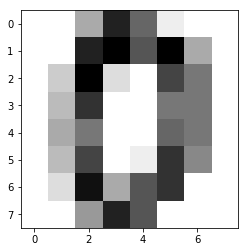

In [339]:
import numpy as np
from sklearn import datasets

%matplotlib inline
import matplotlib.pyplot as plt

#Load the digits dataset
digits = datasets.load_digits().data

# scale between 0 and 1
digits = digits / np.max(digits)

# reshape the data so that each example is an image
n = digits.shape[0]
digits = digits.reshape(n, 8, 8)

# display an image
plt.imshow(digits[0], cmap=plt.cm.gray_r)
plt.show()

### Import what we need from PyTorch

In [340]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

import torchvision.utils as vutils

We will be following the [DCGAN](https://arxiv.org/abs/1511.06434) methodology here. In which both the discriminator and generator are convolutional neural networks. The generator will use a random vector as a seed to build the images from. Using a random vector will cause us to have variability in the generated images.

### Generator

In [341]:
class DCGAN_Generator(nn.Module):
    def __init__(self, featmap_dim=256, n_channel=3, noise_dim=100):
        super(DCGAN_Generator, self).__init__()
        self.featmap_dim = featmap_dim
        self.fc1 = nn.Linear(100, 4 * 4 * featmap_dim)
        self.conv1 = nn.ConvTranspose2d(featmap_dim, 64, kernel_size=2,
                                        stride=1, padding=0, bias=False)
        self.BN1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=2,
                                        stride=1, padding=0, bias=False)
        self.BN2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.ConvTranspose2d(32, 16, kernel_size=2,
                                        stride=1, padding=0, bias=False)
        self.BN3 = nn.BatchNorm2d(16)
        
        self.conv4 = nn.ConvTranspose2d(16, n_channel, kernel_size=2,
                                        stride=1, padding=0, bias=False)

    def forward(self, x):
        """
        Project noise to featureMap * width * height,
        Batch Normalization after convulation but not at output layer,
        ReLU activation function.
        """
        x = self.fc1(x)
        x = x.view(-1, self.featmap_dim, 4, 4)
        x = F.relu(self.BN1(self.conv1(x)))
        x = F.relu(self.BN2(self.conv2(x)))
        x = F.relu(self.BN3(self.conv3(x)))
        x = F.sigmoid(self.conv4(x))

        return x

### Discriminator

In [342]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            # input is 1 x 8 x 8
            nn.Conv2d(1, 32, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 32 x 4 x 4
            nn.Conv2d(32, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.features(input)
        output = output.view(output.size(0), -1)
        #print(output.size())
        output = self.classifier(output)
        return output

### PyTorch data loaders

PyTorch includes some tools to automatically crate data loaders to effeciently stream data into the networks. We'll set one up with the numpy array that contains our MNIST digits.

In [343]:
digits_tch = torch.from_numpy(digits).unsqueeze(1).float()
digits_tch.size()

torch.Size([1797, 1, 8, 8])

In [344]:
# wrap the digits torch tensor in a TensorDataset
# requires labels, remember all real data is label 1
targets = torch.ones(digits_tch.size(0)).unsqueeze(1).float()
digits_train = data.TensorDataset(data_tensor=digits_tch, 
                                  target_tensor=targets)

Now we need to wrap this dataset into a dataloader for efficient processing.

In [345]:
train_loader = data.DataLoader(digits_train,
                               batch_size=16,
                               shuffle=True,
                               num_workers=3)

## Set up the networks, optimizers and loss functions

In [346]:
D = Discriminator()
G = DCGAN_Generator(featmap_dim=128, n_channel=1, noise_dim=25)
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = optim.Adam(G.parameters(), lr=0.0003)

### Create training function

In [347]:
# set up the noise
noise = torch.FloatTensor(16, 100)
fixed_noise = torch.FloatTensor(16, 100).normal_(0,1)

def train(epoch):
    # keep track of accuracy
    total_r = 0
    total_f = 0
    correct_r = 0
    # keep track of losses
    iter_r_loss = 0.
    iter_r_correct = 0.
    iter_f_loss = 0.
    iter_f_correct = 0.
    num_batch_epoch = 0
    # keep track of acc
    total_g = 0
    correct_g = 0
    # keep track of loss
    iter_g_loss = 0.
    iter_g_correct = 0.
    num_batch_epoch = 0.
    for i, data in enumerate(train_loader, 0):
        #################################################
        # Train with Real and test on fake, update D net
        #################################################

        # get the inputs
        inputs, true_labels = data

        # wrap them in Variable
        inputs = Variable(inputs)
        true_labels = Variable(true_labels)

        # zero the parameter gradients
        d_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = D(inputs)
        #print(outputs.data)
        loss_r = criterion(outputs, true_labels)
        loss_r.backward()
        D_x = outputs.data.mean()

        # check accuracy of real data
        predicted = torch.round(outputs.data)
        total_r += true_labels.size(0)
        iter_r_correct += predicted.eq(true_labels.data).sum()

        iter_r_loss += loss_r.data[0]

        # get fake labels
        fake_labels = Variable(torch.zeros(16))
        # get uniform distribution to prime generator
        noisev = Variable(noise.normal_(0,1))
        # generate fake airplane images
        fake_data = G(noisev)
        # predict whether or not the airplane images were real
        fake_out = D(fake_data.detach())
        #print(fake_out.data)
        # calculate loss
        loss_f = criterion(fake_out, fake_labels)
        # do backwards pass
        loss_f.backward()

        # check accuracy of the fake data
        predicted = torch.round(fake_out.data)
        total_f += fake_labels.size(0)
        iter_f_correct += predicted.eq(fake_labels.data).cpu().sum()

        iter_f_loss += loss_f.data[0]

        # update those grads!
        D_G_z1 = fake_out.data.mean()
        loss = loss_r + loss_f
        d_optimizer.step()


        #################################################
        # Train with Fake, update G net
        #################################################

        # get labels
        g_optimizer.zero_grad()
        gen_labels = Variable(torch.ones(16)) # ones this time since we want the generator to get better
        # see what D thinks
        gen_out = D(fake_data)
        #print(gen_out.data)
        # get loss
        g_loss = criterion(gen_out, gen_labels)
        # do the backwards pass
        g_loss.backward()

        # check accuracy of the fake data
        predicted = torch.round(gen_out.data)
        total_g += gen_labels.size(0)
        iter_g_correct += predicted.eq(gen_labels.data).sum()

        iter_g_loss += g_loss.data[0]

        # update weights of generator
        g_optimizer.step()

        num_batch_epoch += 1

    print('\nTrain Real Loss: {:.3} | Train Real Acc: {:.3}'.format(iter_r_loss / num_batch_epoch, 
            float(iter_r_correct) / (num_batch_epoch*16)))

    print('Train Fake Loss: {:.3} | Train Fake Acc: {:.3}'.format(iter_f_loss / num_batch_epoch, 
            float(iter_f_correct) / (num_batch_epoch*16)))

    print('GAN Loss: {:.3} | GAN Acc: {:.3}'.format(iter_g_loss / num_batch_epoch, 
        float(iter_g_correct) / (num_batch_epoch*16)))

    if epoch % 10 == 0:
        vutils.save_image(fake_data.data, 'images/GAN_imgs/generated_digits_' + str(epoch) + '.png', normalize=True)

    return iter_r_loss / num_batch_epoch, iter_f_loss / num_batch_epoch, iter_g_loss / num_batch_epoch


In [348]:
import sys
import time

lr_patience = 0
best_gan_loss = 20.
try:
    print('Training ...')
    D_losses = []
    G_losses = []
    for e in range(50):  # loop over the dataset multiple times
        print('\n' + 'Epoch {}/{}'.format(e, 50))
        start = time.time()

        trl, tfl, tgl = train(e)

        # save the model everytime we get a new best valid loss
        if tgl < best_gan_loss:
            torch.save(G.state_dict(), 'models/digit_gan.pth')
            best_gan_loss = tgl

        print('Time: {}'.format(time.time()-start))

except KeyboardInterrupt:
    pass


print('Finished Training')

Training ...

Epoch 0/50

Train Real Loss: 0.115 | Train Real Acc: 0.985
Train Fake Loss: 0.104 | Train Fake Acc: 0.992
GAN Loss: 2.75 | GAN Acc: 0.0
Time: 3.129142999649048

Epoch 1/50

Train Real Loss: 0.0216 | Train Real Acc: 0.994
Train Fake Loss: 0.0231 | Train Fake Acc: 1.0
GAN Loss: 4.11 | GAN Acc: 0.0
Time: 3.1301209926605225

Epoch 2/50

Train Real Loss: 0.0187 | Train Real Acc: 0.994
Train Fake Loss: 0.0214 | Train Fake Acc: 0.999
GAN Loss: 4.5 | GAN Acc: 0.0
Time: 3.163874864578247

Epoch 3/50

Train Real Loss: 0.143 | Train Real Acc: 0.944
Train Fake Loss: 0.143 | Train Fake Acc: 0.956
GAN Loss: 3.38 | GAN Acc: 0.0194
Time: 3.417105197906494

Epoch 4/50

Train Real Loss: 0.285 | Train Real Acc: 0.881
Train Fake Loss: 0.303 | Train Fake Acc: 0.881
GAN Loss: 2.57 | GAN Acc: 0.0774
Time: 3.334590196609497

Epoch 5/50

Train Real Loss: 0.308 | Train Real Acc: 0.87
Train Fake Loss: 0.301 | Train Fake Acc: 0.872
GAN Loss: 2.39 | GAN Acc: 0.0785
Time: 3.3093628883361816

Epoch 6/5

Random Init


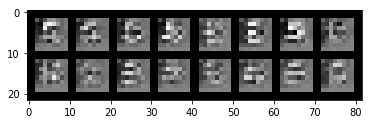

After 30 iterations


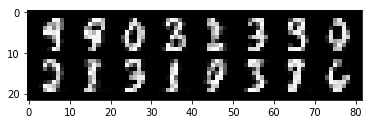

In [351]:
import matplotlib.image as mpimg

print('Random Init')
plt.imshow(mpimg.imread('images/GAN_imgs/generated_digits_0.png'))
plt.show()

print('After 30 iterations')
plt.imshow(mpimg.imread('images/GAN_imgs/generated_digits_30.png'))
plt.show()